In [10]:
!pip install igor2

  Using cached igor2-0.5.9-py3-none-any.whl.metadata (2.7 kB)
Using cached igor2-0.5.9-py3-none-any.whl (32 kB)


In [11]:
!pip install SciFiReaders

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import SciFiReaders
import glob
#from scipy.optimize import curve_fit

You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.


In [6]:
ibw_file = "/home/shawn-patrick/Desktop/material1_perovksite/Image_10um_01.ibw"

In [7]:
reader = SciFiReaders.IgorIBWReader(ibw_file)
data = reader.read()

{'Channel_000': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float32, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: HeightRetrace (m)
 and Dimensions: 
x:  x (m) of size (256,)
y:  y (m) of size (256,), 'Channel_001': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float32, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: DeflectionRetrace (m)
 and Dimensions: 
x:  x (m) of size (256,)
y:  y (m) of size (256,), 'Channel_002': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float32, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: ZSensorRetrace (m)
 and Dimensions: 
x:  x (m) of size (256,)
y:  y (m) of size (256,)}

<class 'sidpy.sid.dataset.Dataset'>


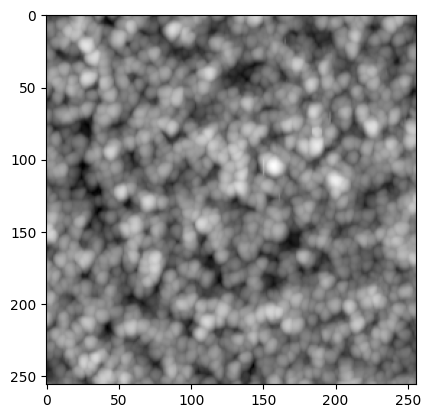

In [8]:
print(data)

height = data['Channel_000']

print('')
print(type(height))
img = np.array(height)

plt.imshow(img, cmap='gray')

# Segmenting normalised image

In [9]:
from cellSAM import segment_cellular_image

img = np.array(height)
img = (img-np.min(img))/np.ptp(img)
print(np.min(img), np.max(img))
mask, embedding, bounding_boxes = segment_cellular_image(img)
plt.matshow(mask)

ModuleNotFoundError: No module named 'cellSAM'

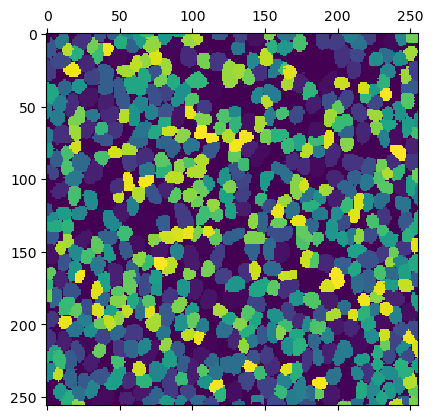

In [40]:
plt.matshow(mask)
plt.savefig("C:/Users/alexa/Downloads/mask.png")

# Selecting samples from grains of different sizes

In [120]:
from scipy.ndimage import center_of_mass

# Find the sizes of the different particles
sizes = np.zeros(np.max(mask)+1)

for ii in range(np.max(mask)+1):
    sizes[ii] = np.count_nonzero(mask==ii)

# Remove the zeroth element (the background)
sizes_new = sizes[1:]

# Bin these clusters by size
bins = 20
hist = np.histogram(sizes_new, bins=bins)
bin_boundaries = hist[1]

# Find the corresponding indices
size_args = []

for ii in range(bins):
    bounds = (bin_boundaries[ii], bin_boundaries[ii+1])
    bool_arr = np.array([sizes_new>=bounds[0], sizes_new<bounds[1]])
    size_args.append(list(np.argwhere(bool_arr.all(0)).T[0]))

# Take samples from each bin
no_of_samples = 3
sample_list = []

for ii in range(bins):
    #print(ii)
    if len(size_args[ii])>no_of_samples:
        sample_list.append(list(np.random.choice(size_args[ii], size=3, replace=False)))
    else:
        sample_list.append(size_args[ii])

# Find the pixel co-ordinates of these samples
coords = []

for ii in range(bins):
    sl = sample_list[ii]
    coord_ii = []
    for jj in range(len(sl)):
        mask_ii = mask==(ii+1) # +1 needed because we subtracted the zeroth element earlier
        coord_ii.append(center_of_mass(mask_ii))
    coords.append(coord_ii)

# Selecting areas with numerous grain boundaries (edges in the mask)

[[170. 200.]
 [160.  84.]
 [ 17.  74.]
 [139.  89.]
 [ 77. 131.]
 [198.  74.]
 [ 26. 131.]
 [105. 174.]
 [ 94. 104.]
 [156. 181.]]


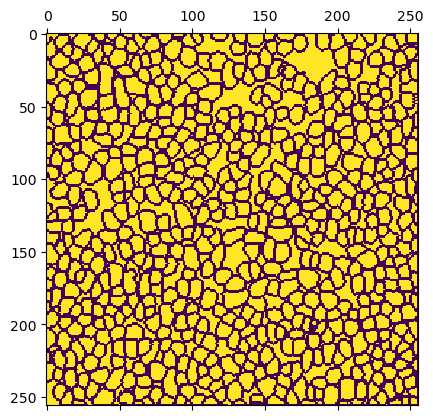

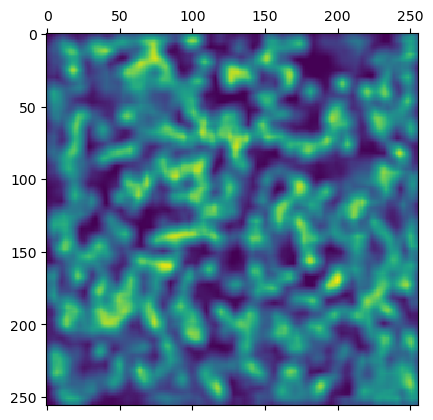

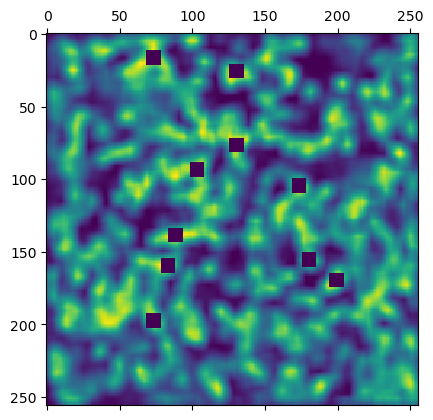

In [47]:
from scipy import signal

# Common edge detection method for grayscale images (perfect for this)
roll_up = np.roll(mask, 1, axis=0)
roll_down = np.roll(mask, -1, axis=0)
roll_left = np.roll(mask, 1, axis=1)
roll_right = np.roll(mask, -1, axis=1)

up = (mask==roll_up).astype(int)
down = (mask==roll_down).astype(int)
left = (mask==roll_left).astype(int)
right = (mask==roll_right).astype(int)

edges = up*down*left*right
plt.matshow(edges)

# Convolve kernel with edges to find regions with highest density of boundaries
ks = 10 # kernel size
kernel2d = np.ones((ks,ks))

boundary_density = signal.convolve2d(mask, kernel2d, mode='same', boundary='fill')
plt.matshow(boundary_density)

# Generate scan target coordinates
scan_size = 10
n_targets = 10

target_map = boundary_density.copy()

coords = np.zeros((n_targets, 2))

for ii in range(n_targets):
    coord = np.unravel_index(np.argmax(target_map), target_map.shape) # Find maximum density of boundaries in the current target map
    x_min = np.max((int(coord[1]-scan_size/2), 0))
    x_max = np.min((int(coord[1]+scan_size/2), target_map.shape[1]))
    y_min = np.max((int(coord[0]-scan_size/2), 0))
    y_max = np.min((int(coord[0]+scan_size/2), target_map.shape[1]))
    target_map[y_min:y_max, x_min:x_max] = 0 # Block out an area of scan_size**2 around to stop repeat imaging of the same region.

    coords[ii] = coord

print(coords)
plt.matshow(target_map)